## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\pastis\\full\\wavelet\\blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


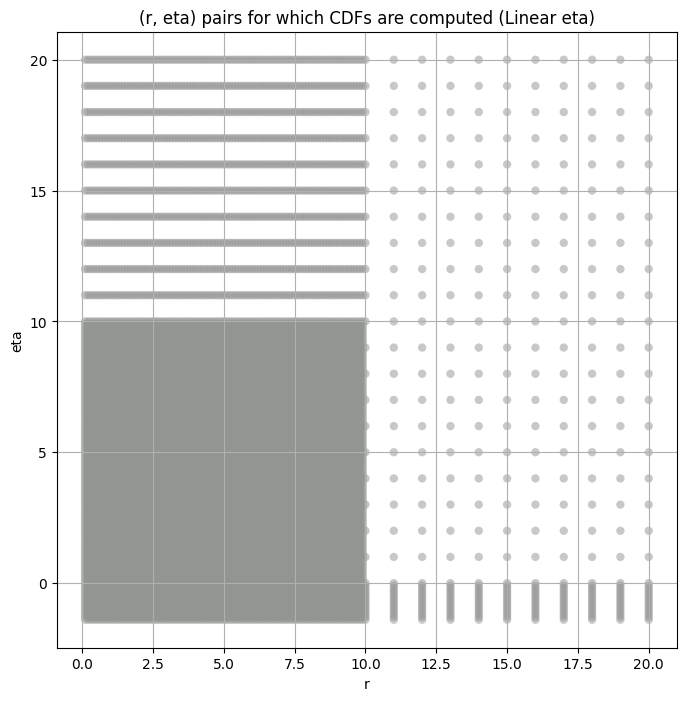

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:43<00:00, 2277.22it/s]


Layer 3


100%|██████████| 100000/100000 [00:54<00:00, 1844.42it/s]


Layer 4


100%|██████████| 100000/100000 [00:54<00:00, 1849.70it/s]


Layer 5


100%|██████████| 100000/100000 [01:06<00:00, 1511.27it/s]


Layer 6


100%|██████████| 100000/100000 [01:04<00:00, 1555.43it/s]


Layer 7


100%|██████████| 100000/100000 [01:02<00:00, 1610.26it/s]


Layer 8


100%|██████████| 100000/100000 [01:04<00:00, 1546.33it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2543.706000  2322.266800  2776.369900   1.855184    1.231146   
3       880.942400   837.707600   925.666000   1.832932    1.492253   
4       249.724290   236.018890   263.695700   2.604847    2.158933   
5        56.870796    53.349483    60.484978   4.033042    3.357861   
6        10.734995     9.960573    11.537709   5.936091    4.932771   
7         1.834359     1.688523     1.988222   8.154408    6.703937   
8         0.259103     0.236675     0.283873  10.494855    7.995214   

       kurt_upper  total_samples  
layer                             
2        2.552742         3180.0  
3        2.208135        12720.0  
4        3.140816        50880.0  
5        4.833753       203520.0  
6        7.195107       814080.0  
7       10.309594      3256320.0  
8       17.801400     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      2543.706000    2543.706055     2088.534668     1853.452881   
3       880.942400     880.942383      824.122986      786.903992   
4       249.724290     249.724289      243.715408      239.253052   
5        56.870796      56.870796       55.848534       55.077679   
6        10.734995      10.734995       10.497361       10.319826   
7         1.834359       1.834359        1.784488        1.748109   
8         0.259103       0.259103        0.250341        0.244581   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1679.841553      1536.572144      1301.713501      1121.535645   
3          756.733643       730.475464       684.616455       644.421265   
4          235.397263       231.861053       225.532074       219.856186   
5           54.401211        53.783310        52.676426        51.681858   
6           10.164819        10.023976         9.770719         9.545079   
7            1.716584         1.688150         1.637469         1.592736   
8            0.239644         0.235222         0.227424         0.220602   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           974.144470       849.254761       743.180908       499.858826  
3           608.818848       577.090820       548.731934       478.136169  
4           214.682373       209.908356       205.487411       193.601685  
5            50.778111        49.943874        49.162212        47.060429  
6             9.339422         9.149346         8.972178         8.502852  
7             1.552345         1.515384         1.481188         1.391240  
8             0.214479         0.208891         0.203733         0.190242

####
Layer  2


100%|██████████| 12760/12760 [00:04<00:00, 2869.89it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.015628688296518922 2543.706


100%|██████████| 12760/12760 [00:04<00:00, 3098.86it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.0178066378477727 2088.5347


100%|██████████| 12760/12760 [00:03<00:00, 3241.36it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.027708025912250966 1853.4529


100%|██████████| 12760/12760 [00:03<00:00, 3247.08it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.03591249253415785 1679.8416


100%|██████████| 12760/12760 [00:03<00:00, 3259.31it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.043920445589807455 1536.5721


100%|██████████| 12760/12760 [00:03<00:00, 3221.48it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.06040296571231252 1301.7135


100%|██████████| 12760/12760 [00:04<00:00, 3037.99it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07497339787793122 1121.5356


100%|██████████| 12760/12760 [00:04<00:00, 3103.56it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.08738858504120739 974.1445


100%|██████████| 12760/12760 [00:04<00:00, 3076.05it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.09880364033346978 849.25476


100%|██████████| 12760/12760 [00:03<00:00, 3201.11it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11344832232859237 743.1809


100%|██████████| 12760/12760 [00:04<00:00, 3024.07it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.15796969127569316 499.85883
Number of samples: 3180, Without approximation : 3180.0


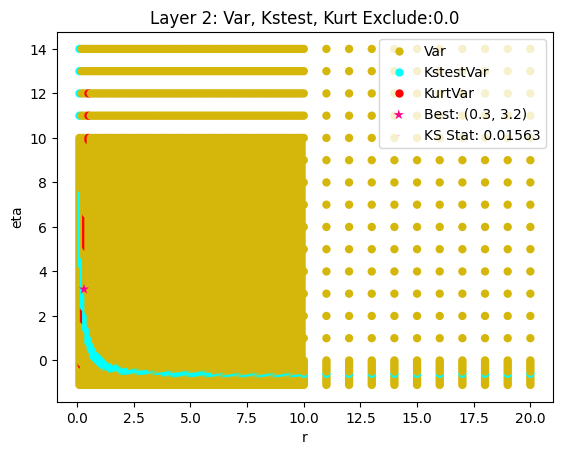

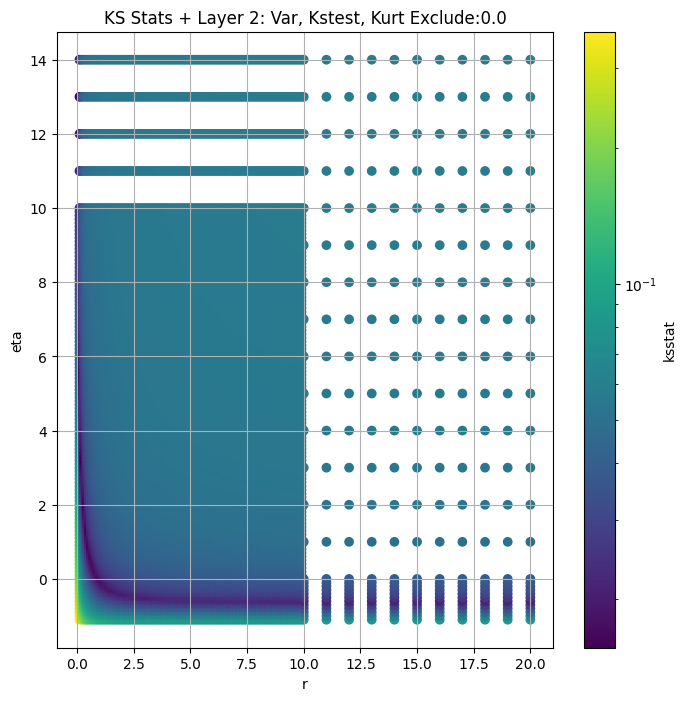

####
Layer  3


100%|██████████| 12760/12760 [00:14<00:00, 883.28it/s] 


Finding Minimum after computing 12760 CDFs
3 0 0.004665139800278717 880.9424


100%|██████████| 12760/12760 [00:14<00:00, 901.82it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.006687512400948337 824.123


100%|██████████| 12760/12760 [00:14<00:00, 901.92it/s] 


Finding Minimum after computing 12760 CDFs
3 50 0.008670898344027789 786.904


100%|██████████| 12760/12760 [00:14<00:00, 887.20it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.010387260479332694 756.73364


100%|██████████| 12760/12760 [00:14<00:00, 905.04it/s] 


Finding Minimum after computing 12760 CDFs
3 100 0.012675597306140762 730.47546


100%|██████████| 12760/12760 [00:13<00:00, 945.84it/s] 


Finding Minimum after computing 12760 CDFs
3 150 0.0165061368087831 684.61646


100%|██████████| 12760/12760 [00:13<00:00, 948.48it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.02090281542620287 644.42126


100%|██████████| 12760/12760 [00:13<00:00, 949.75it/s] 


Finding Minimum after computing 12760 CDFs
3 250 0.025298440387699572 608.81885


100%|██████████| 12760/12760 [00:13<00:00, 932.50it/s] 


Finding Minimum after computing 12760 CDFs
3 300 0.02986909400484905 577.0908


100%|██████████| 12760/12760 [00:14<00:00, 909.85it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03413302990353828 548.73193


100%|██████████| 12760/12760 [00:14<00:00, 901.19it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.04631807421197365 478.13617
Number of samples: 12720, Without approximation : 12720.0


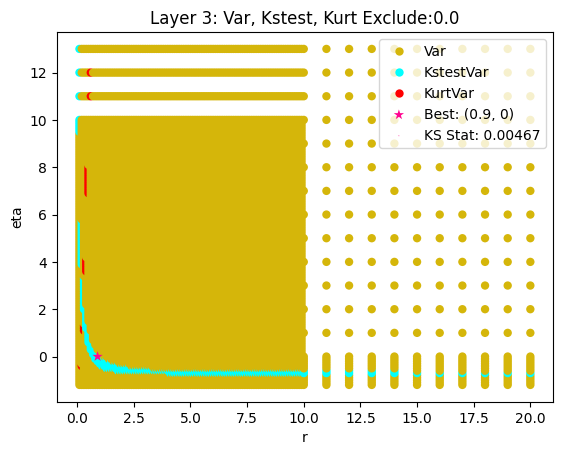

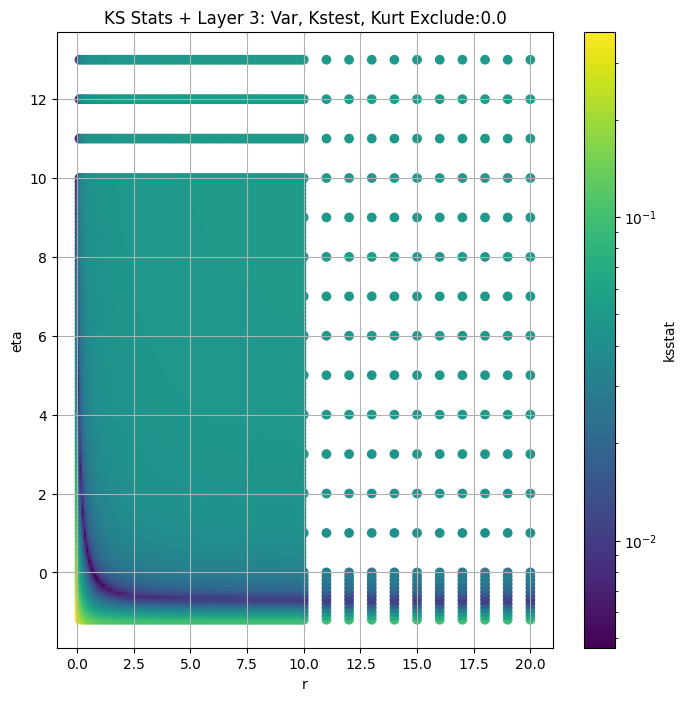

####
Layer  4


100%|██████████| 12760/12760 [00:54<00:00, 232.52it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005306463266761097 249.72429


100%|██████████| 12760/12760 [00:55<00:00, 229.25it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.004866485208134486 243.71541


100%|██████████| 12760/12760 [00:55<00:00, 229.71it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.0053075918455732785 239.25305


100%|██████████| 12760/12760 [00:53<00:00, 237.44it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.0055930103547947585 235.39726


100%|██████████| 12760/12760 [00:58<00:00, 216.95it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.006016568167322323 231.86105


100%|██████████| 12760/12760 [00:58<00:00, 217.68it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.007020491346896973 225.53207


100%|██████████| 12760/12760 [00:58<00:00, 218.56it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00821199393239902 219.85619


100%|██████████| 12760/12760 [00:55<00:00, 229.27it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.009307095550768696 214.68237


100%|██████████| 12760/12760 [00:57<00:00, 222.92it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010352932420849448 209.90836


100%|██████████| 12760/12760 [00:55<00:00, 228.07it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011407252356945063 205.48741


100%|██████████| 12760/12760 [00:55<00:00, 229.44it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.01457157151741384 193.60168
Number of samples: 50880, Without approximation : 50880.0


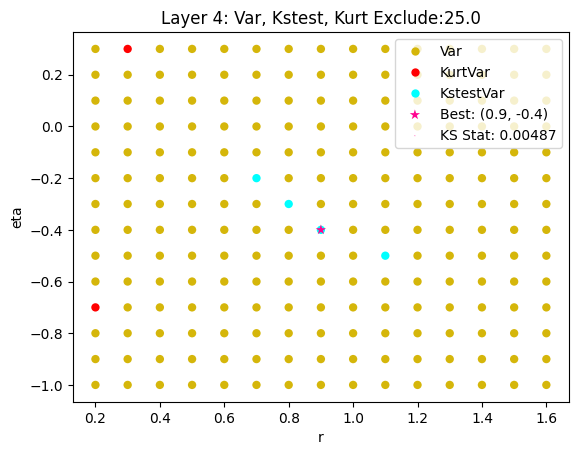

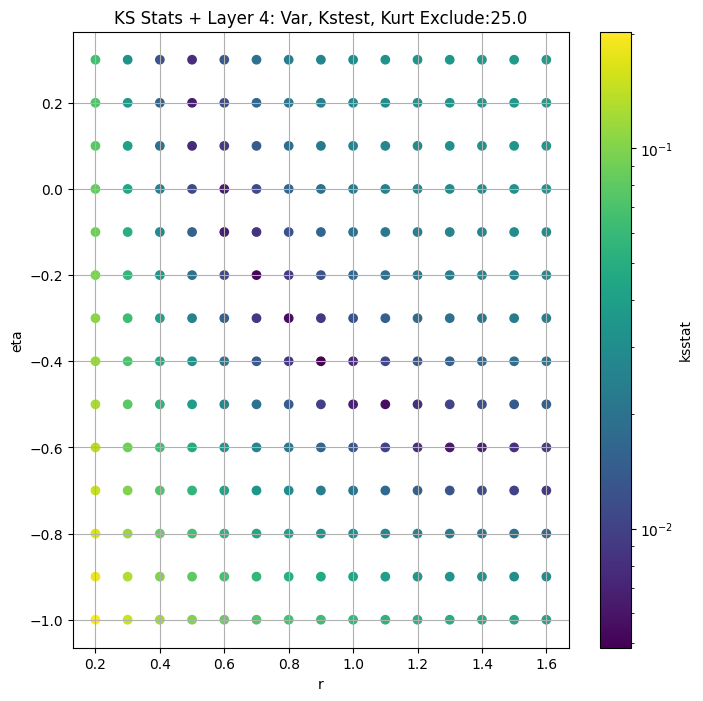

####
Layer  5


100%|██████████| 12760/12760 [01:56<00:00, 109.40it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.002479101519312743 56.870796


100%|██████████| 12760/12760 [02:00<00:00, 105.92it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.002843071725276647 55.848534


100%|██████████| 12760/12760 [01:58<00:00, 108.08it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.0033984387095991053 55.07768


100%|██████████| 12760/12760 [02:02<00:00, 103.86it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0036556537219725183 54.40121


100%|██████████| 12760/12760 [02:02<00:00, 104.10it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.0038786639568137993 53.78331


100%|██████████| 12760/12760 [01:57<00:00, 108.84it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.004715643162785277 52.676426


100%|██████████| 12760/12760 [01:58<00:00, 108.12it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.005111609528183569 51.681858


100%|██████████| 12760/12760 [01:46<00:00, 120.28it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.00573198044418799 50.77811


100%|██████████| 12760/12760 [01:43<00:00, 123.76it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006402495146159648 49.943874


100%|██████████| 12760/12760 [01:59<00:00, 106.87it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007034568902312577 49.162212


100%|██████████| 12760/12760 [01:53<00:00, 112.53it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008447162008738962 47.06043
Number of samples: 100000, Without approximation : 203520.0


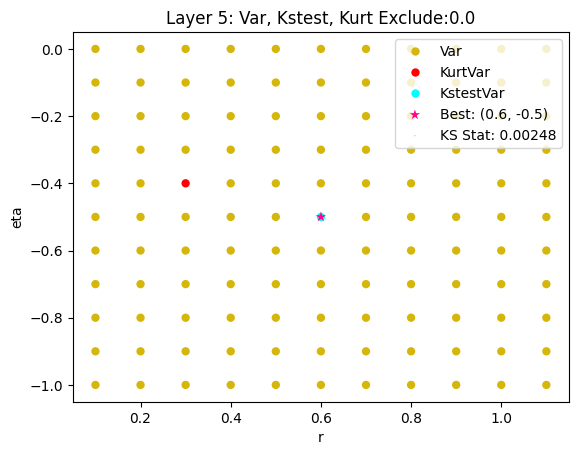

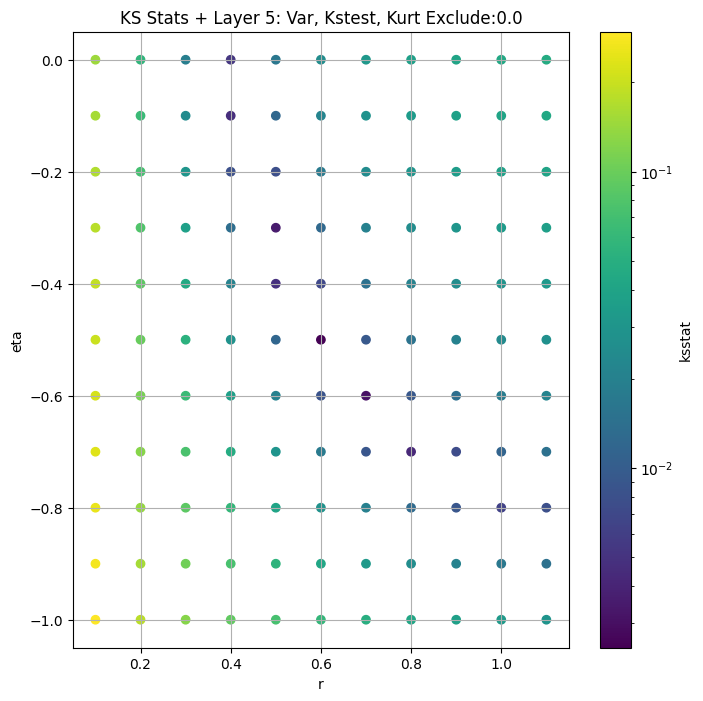

####
Layer  6


100%|██████████| 12760/12760 [02:03<00:00, 103.47it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.0038231443277501054 10.734995


100%|██████████| 12760/12760 [01:59<00:00, 107.08it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.004595780331112187 10.497361


100%|██████████| 12760/12760 [02:01<00:00, 105.15it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.0052710931149849705 10.319826


100%|██████████| 12760/12760 [02:03<00:00, 103.73it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.004405570911676926 10.164819


100%|██████████| 12760/12760 [02:03<00:00, 103.67it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.004704596757522217 10.023976


100%|██████████| 12760/12760 [02:01<00:00, 105.08it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.005030792497920822 9.770719


100%|██████████| 12760/12760 [02:02<00:00, 103.75it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005934736796303519 9.545079


100%|██████████| 12760/12760 [01:54<00:00, 111.49it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.006555819834839327 9.339422


100%|██████████| 12760/12760 [02:05<00:00, 101.59it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006729303270139875 9.149346


100%|██████████| 12760/12760 [02:01<00:00, 105.38it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.007462116992366208 8.9721775


100%|██████████| 12760/12760 [02:02<00:00, 103.88it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008793772343010597 8.502852
Number of samples: 100000, Without approximation : 814080.0


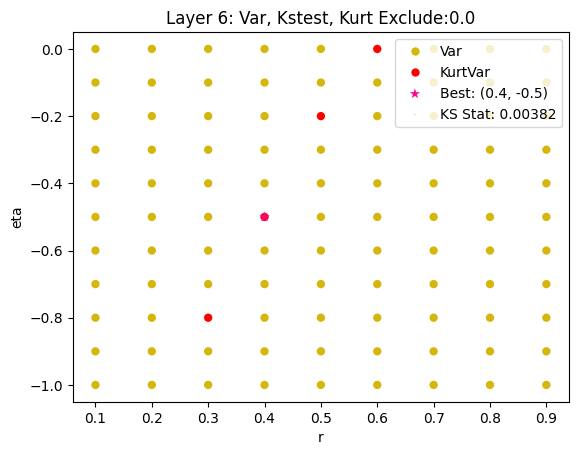

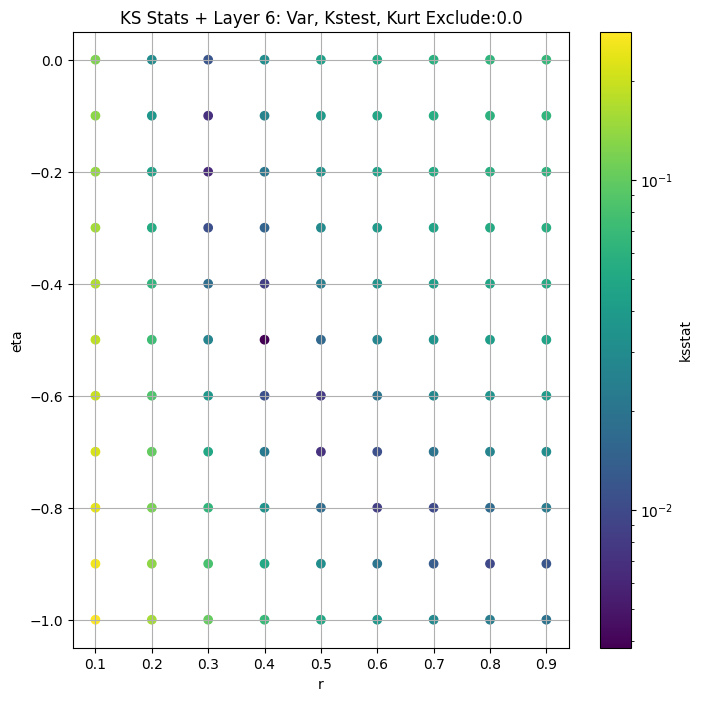

####
Layer  7


100%|██████████| 12760/12760 [01:45<00:00, 120.63it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.0072675615468815735 1.834359


100%|██████████| 12760/12760 [01:41<00:00, 126.11it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.007587881908422411 1.7844876


100%|██████████| 12760/12760 [01:46<00:00, 119.38it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.007234167212921305 1.7481095


100%|██████████| 12760/12760 [01:45<00:00, 120.61it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.007472047270219717 1.7165837


100%|██████████| 12760/12760 [01:45<00:00, 120.59it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.007726845139553906 1.6881497


100%|██████████| 12760/12760 [01:46<00:00, 119.43it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.009018183913415911 1.6374687


100%|██████████| 12760/12760 [01:43<00:00, 123.83it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.0078607073111146 1.5927364


100%|██████████| 12760/12760 [01:42<00:00, 124.34it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.008594606959225204 1.5523447


100%|██████████| 12760/12760 [01:44<00:00, 121.90it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.009753471283347248 1.5153842


100%|██████████| 12760/12760 [01:46<00:00, 120.20it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.009250026692025348 1.4811882


100%|██████████| 12760/12760 [01:47<00:00, 118.51it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.010565145874336657 1.3912402
Number of samples: 100000, Without approximation : 3256320.0


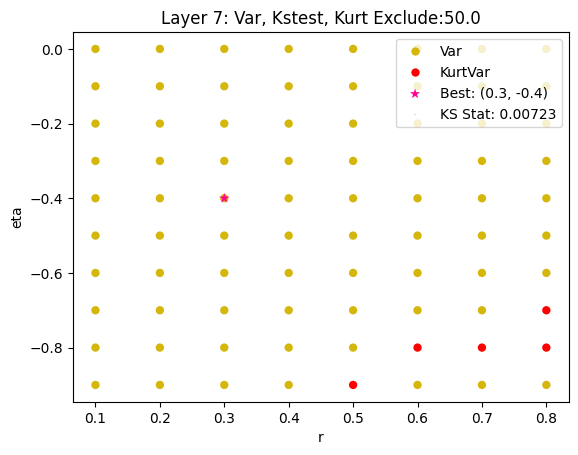

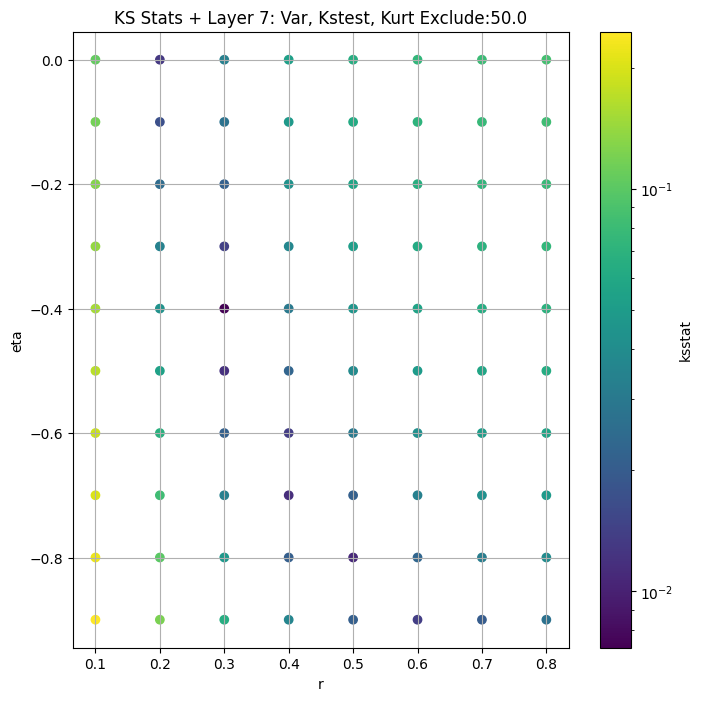

####
Layer  8


100%|██████████| 12760/12760 [01:44<00:00, 121.65it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.024759999999995563 0.25910306


100%|██████████| 12760/12760 [01:42<00:00, 124.80it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.024759999999995452 0.25034106


100%|██████████| 12760/12760 [01:43<00:00, 123.51it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.02475999999999523 0.24458127


100%|██████████| 12760/12760 [01:45<00:00, 121.43it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.024759999999995674 0.23964441


100%|██████████| 12760/12760 [01:43<00:00, 123.12it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.024759999999995674 0.23522173


100%|██████████| 12760/12760 [01:42<00:00, 124.52it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.024759999999995674 0.22742407


100%|██████████| 12760/12760 [01:42<00:00, 124.07it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.024759999999995563 0.22060172


100%|██████████| 12760/12760 [01:42<00:00, 124.28it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.024759999999995452 0.21447906


100%|██████████| 12760/12760 [01:42<00:00, 124.42it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.024759999999995563 0.20889148


100%|██████████| 12760/12760 [01:43<00:00, 123.77it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.024759999999995452 0.20373315


100%|██████████| 12760/12760 [01:43<00:00, 123.15it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.024759999999995452 0.19024237
Number of samples: 100000, Without approximation : 13025280.0


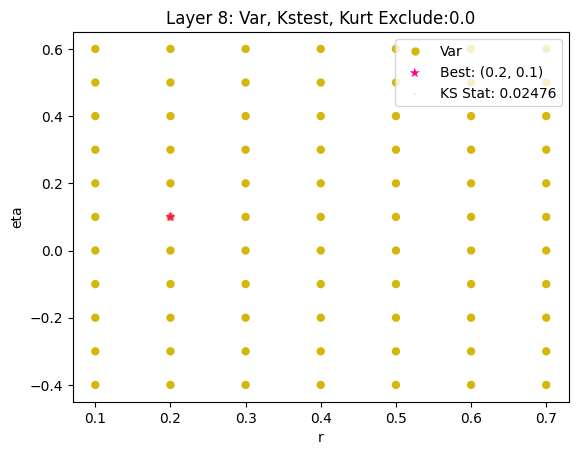

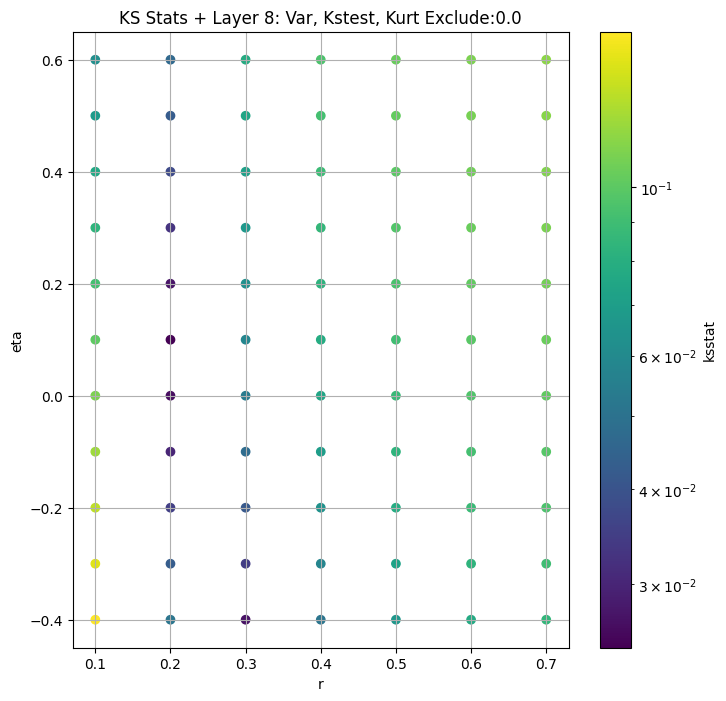

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2543.706000  2322.266800  2776.369900   1.855184    1.231146   
3       880.942400   837.707600   925.666000   1.832932    1.492253   
4       249.724290   236.018890   263.695700   2.604847    2.158933   
5        56.870796    53.349483    60.484978   4.033042    3.357861   
6        10.734995     9.960573    11.537709   5.936091    4.932771   
7         1.834359     1.688523     1.988222   8.154408    6.703937   
8         0.259103     0.236675     0.283873  10.494855    7.995214   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.552742         3180.0             0.015629        0.3          3.2   
3        2.208135        12720.0             0.004665        0.9          0.0   
4        3.140816        50880.0             0.004866        0.9         -0.4   
5        4.833753       203520.0             0.002479        0.6         -0.5   
6        7.195107       814080.0             0.003823        0.4         -0.5   
7       10.309594      3256320.0             0.007234        0.3         -0.4   
8       17.801400     13025280.0             0.024760        0.2          0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.209118                     0.0         2543.706000   
3         483.256384                     0.0          880.942400   
4         186.797253                    25.0          243.715410   
5          18.479811                     0.0           56.870796   
6           0.594603                     0.0           10.734995   
7           0.009741                    50.0            1.748109   
8           0.000003                     0.0            0.259103   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 702/702 [00:00<00:00, 2554.37it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0492900105485381, var: 1536.5721435546875


100%|██████████| 702/702 [00:00<00:00, 3573.36it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04052369122622135, var: 1679.841552734375


100%|██████████| 702/702 [00:00<00:00, 3920.95it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.03076141682282829, var: 1853.452880859375


100%|██████████| 702/702 [00:00<00:00, 3411.36it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02034328206429381, var: 2088.53466796875


100%|██████████| 702/702 [00:00<00:00, 3345.41it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.015555500502709041, var: 2543.7060546875
Number of samples: 3180, Without approximation : 3180.0


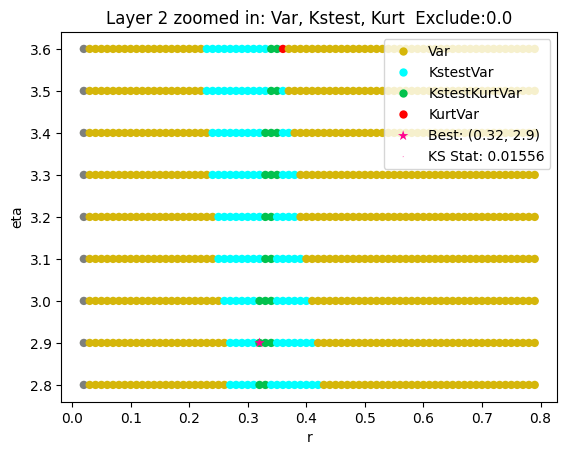

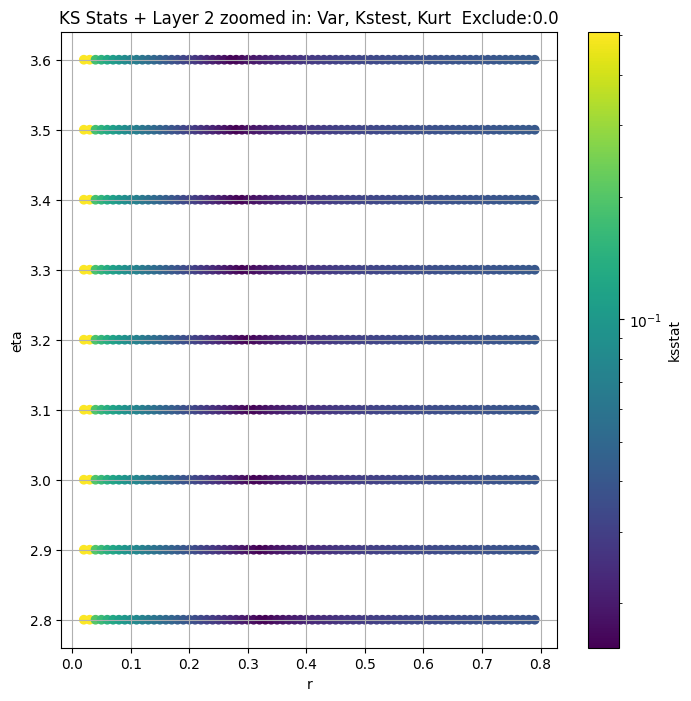

Layer 3


100%|██████████| 1350/1350 [00:01<00:00, 941.28it/s]


Finding Minimum after computing 1350 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.014145397893200129, var: 730.4754638671875


100%|██████████| 1350/1350 [00:01<00:00, 1037.10it/s]


Finding Minimum after computing 1350 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.011853917553142024, var: 756.733642578125


100%|██████████| 1350/1350 [00:01<00:00, 979.68it/s] 


Finding Minimum after computing 1350 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.00945630868609637, var: 786.9039916992188


100%|██████████| 1350/1350 [00:01<00:00, 1025.94it/s]


Finding Minimum after computing 1350 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.006756716831834542, var: 824.1229858398438


100%|██████████| 1350/1350 [00:01<00:00, 1009.94it/s]


Finding Minimum after computing 1350 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004410721167727394, var: 880.9423828125
Number of samples: 12720, Without approximation : 12720.0


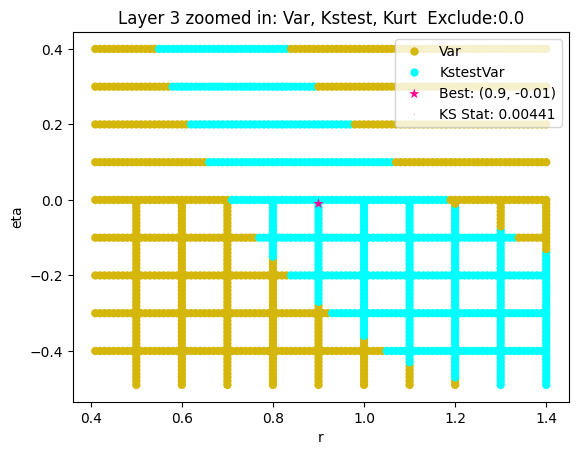

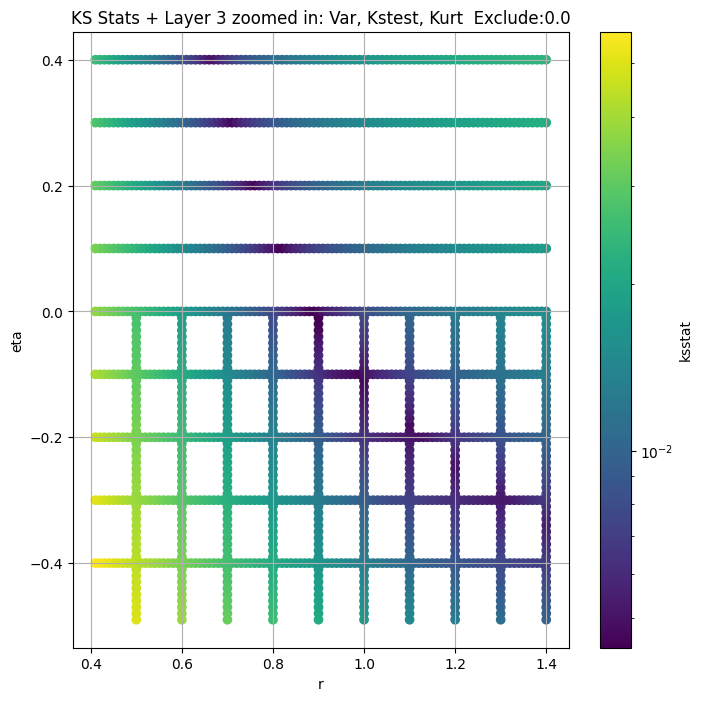

Layer 4


100%|██████████| 1710/1710 [00:06<00:00, 258.35it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.006759374704111476, var: 228.5842742919922


100%|██████████| 1710/1710 [00:06<00:00, 259.72it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.006072287432300261, var: 231.86105346679688


100%|██████████| 1710/1710 [00:06<00:00, 255.42it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.005457815811017008, var: 235.3972625732422


100%|██████████| 1710/1710 [00:06<00:00, 269.29it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.004991029915057732, var: 239.2530517578125


100%|██████████| 1710/1710 [00:06<00:00, 274.47it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.004866485208134486, var: 243.7154083251953


100%|██████████| 1710/1710 [00:06<00:00, 272.59it/s]


Finding Minimum after computing 1710 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.0048533118990581325, var: 249.7242889404297
Number of samples: 50880, Without approximation : 50880.0


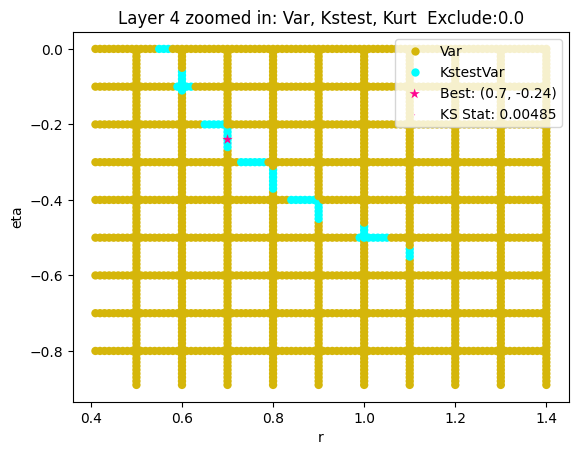

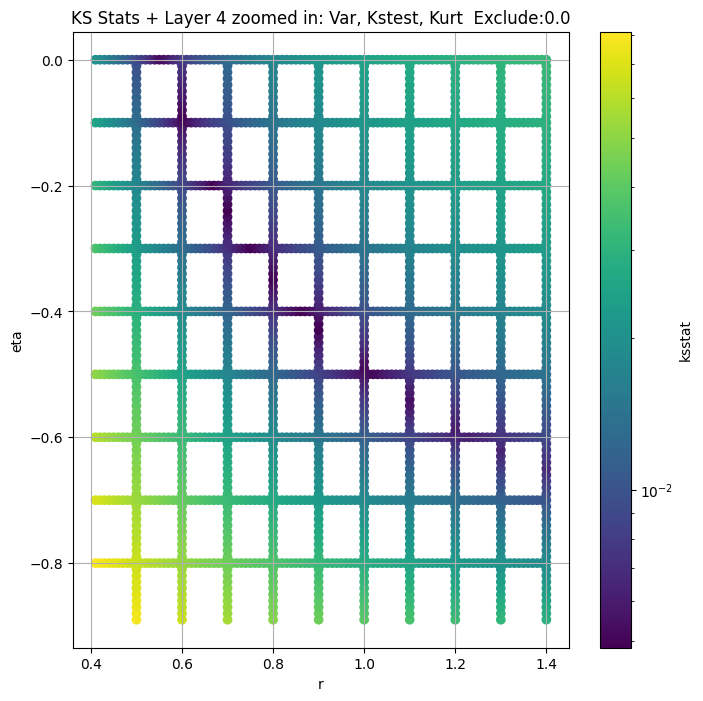

Layer 5


100%|██████████| 1701/1701 [00:13<00:00, 124.76it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.003847202884595058, var: 53.78330993652344


100%|██████████| 1701/1701 [00:13<00:00, 123.69it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0034389166050158293, var: 54.40121078491211


100%|██████████| 1701/1701 [00:13<00:00, 122.80it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0031232833375544056, var: 55.07767868041992


100%|██████████| 1701/1701 [00:13<00:00, 128.44it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.002816066871744849, var: 55.848533630371094


100%|██████████| 1701/1701 [00:13<00:00, 123.84it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0024390048317627366, var: 56.87079620361328
Number of samples: 100000, Without approximation : 203520.0


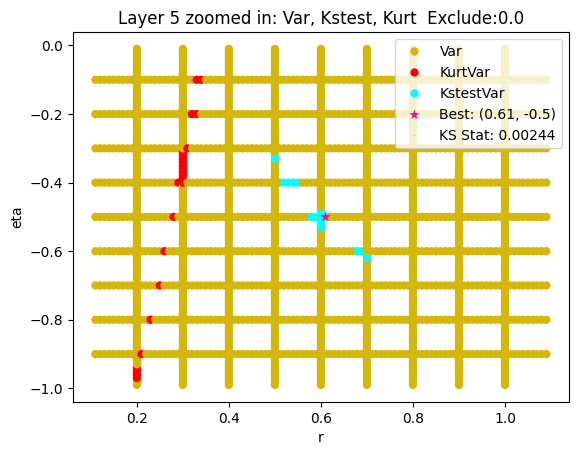

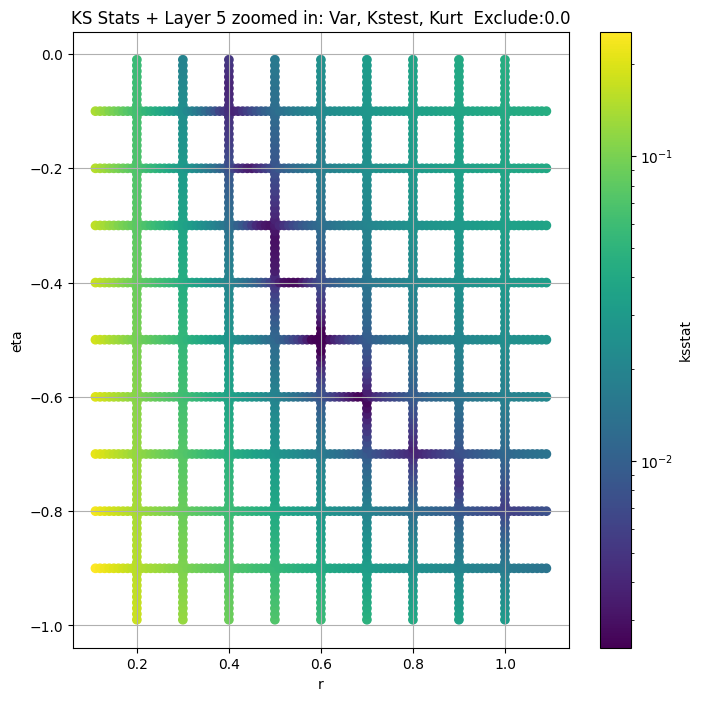

Layer 6


100%|██████████| 1512/1512 [00:12<00:00, 120.63it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.0043986641698845474, var: 10.02397632598877


100%|██████████| 1512/1512 [00:12<00:00, 122.75it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.004182406937312089, var: 10.16481876373291


100%|██████████| 1512/1512 [00:12<00:00, 124.99it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.00373507096328074, var: 10.319826126098633


100%|██████████| 1512/1512 [00:12<00:00, 123.47it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.0036459250255561626, var: 10.497361183166504


100%|██████████| 1512/1512 [00:12<00:00, 125.63it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.00329302688003974, var: 10.734994888305664
Number of samples: 100000, Without approximation : 814080.0


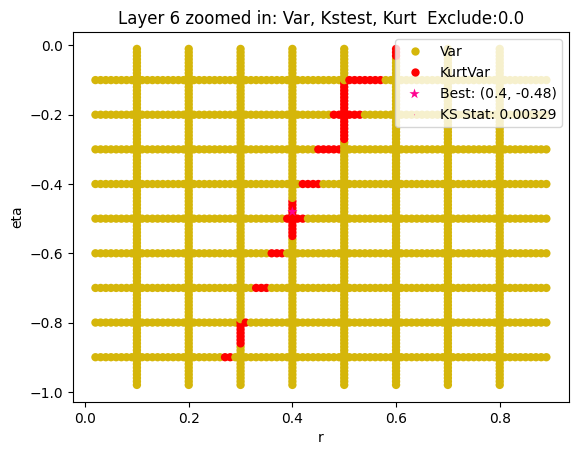

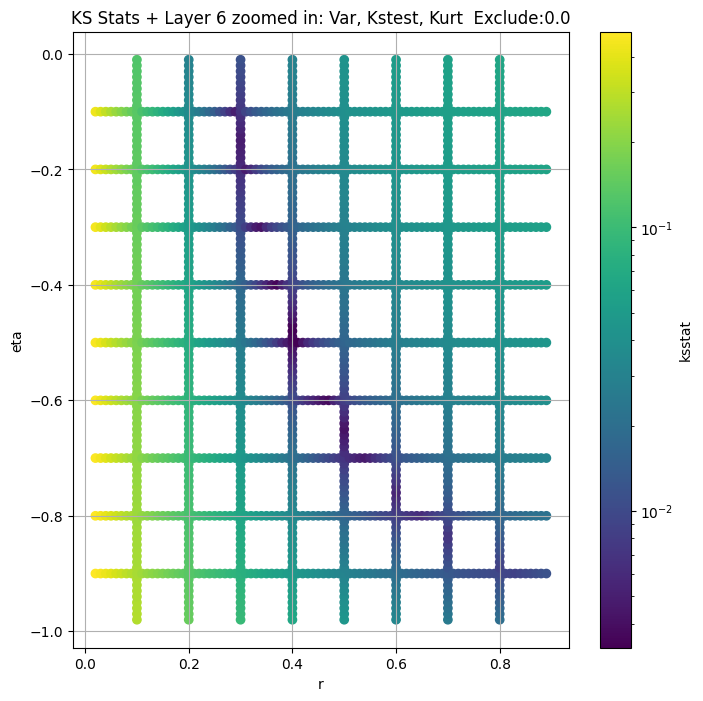

Layer 7


100%|██████████| 1269/1269 [00:09<00:00, 127.02it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.007257027534442295, var: 1.637468695640564


100%|██████████| 1269/1269 [00:10<00:00, 125.23it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.007629028211059152, var: 1.6619150638580322


100%|██████████| 1269/1269 [00:10<00:00, 124.62it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.006886020361214273, var: 1.6881496906280518


100%|██████████| 1269/1269 [00:10<00:00, 125.48it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.0069235740230760845, var: 1.7165837287902832


100%|██████████| 1269/1269 [00:10<00:00, 121.87it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.007039236916615621, var: 1.7481094598770142


100%|██████████| 1269/1269 [00:10<00:00, 123.92it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.006642154410704371, var: 1.7844876050949097


100%|██████████| 1269/1269 [00:10<00:00, 125.46it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.006393851448109833, var: 1.834359049797058
Number of samples: 100000, Without approximation : 3256320.0


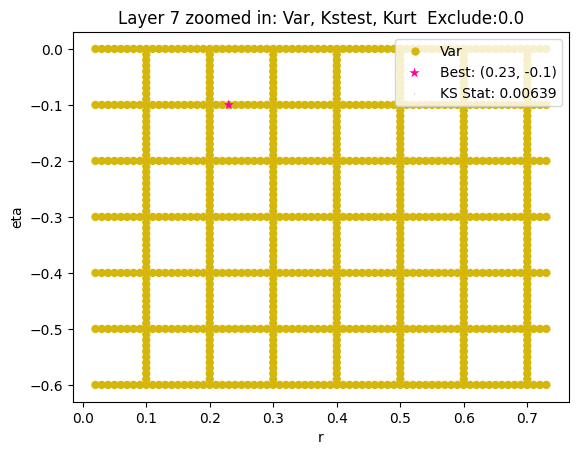

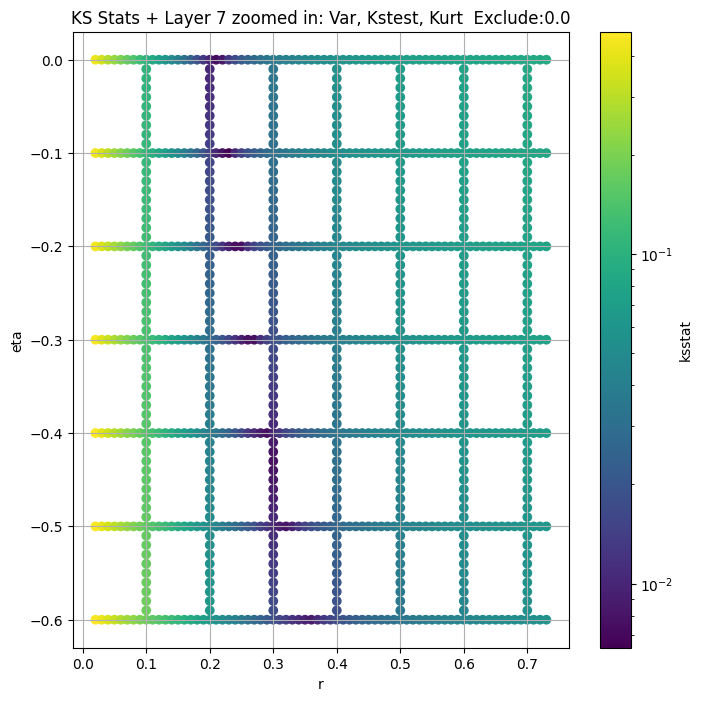

Layer 8


100%|██████████| 873/873 [00:07<00:00, 119.95it/s]


Finding Minimum after computing 873 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.02475999999999523, var: 0.235221728682518


100%|██████████| 873/873 [00:07<00:00, 123.48it/s]


Finding Minimum after computing 873 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.02475999999999534, var: 0.23964440822601318


100%|██████████| 873/873 [00:07<00:00, 124.48it/s]


Finding Minimum after computing 873 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.02475999999999523, var: 0.24458126723766327


100%|██████████| 873/873 [00:07<00:00, 124.55it/s]


Finding Minimum after computing 873 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.02475999999999523, var: 0.2503410577774048


100%|██████████| 873/873 [00:07<00:00, 120.71it/s]


Finding Minimum after computing 873 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.02475999999999534, var: 0.25910305976867676
Number of samples: 100000, Without approximation : 13025280.0


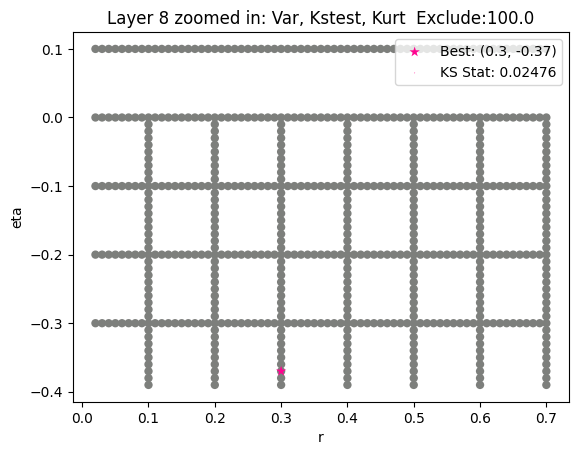

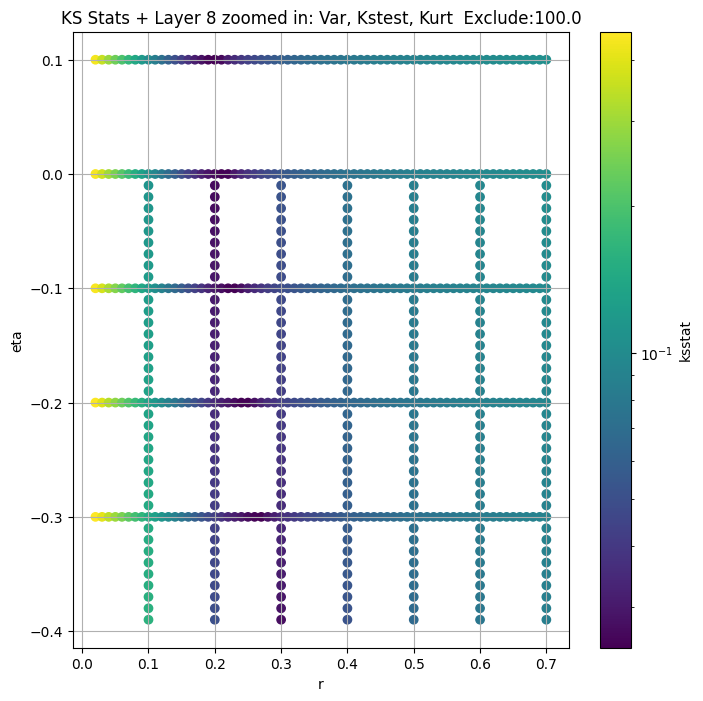

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2543.706000  2322.266800  2776.369900   1.855184    1.231146   
3       880.942400   837.707600   925.666000   1.832932    1.492253   
4       249.724290   236.018890   263.695700   2.604847    2.158933   
5        56.870796    53.349483    60.484978   4.033042    3.357861   
6        10.734995     9.960573    11.537709   5.936091    4.932771   
7         1.834359     1.688523     1.988222   8.154408    6.703937   
8         0.259103     0.236675     0.283873  10.494855    7.995214   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.552742         3180.0             0.015629        0.3          3.2   
3        2.208135        12720.0             0.004665        0.9          0.0   
4        3.140816        50880.0             0.004866        0.9         -0.4   
5        4.833753       203520.0             0.002479        0.6         -0.5   
6        7.195107       814080.0             0.003823        0.4         -0.5   
7       10.309594      3256320.0             0.007234        0.3         -0.4   
8       17.801400     13025280.0             0.024760        0.2          0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.209118                     0.0         2543.706055   
3         483.256384                     0.0          880.942383   
4         186.797253                    25.0          249.724289   
5          18.479811                     0.0           56.870796   
6           0.594603                     0.0           10.734995   
7           0.009741                    50.0            1.834359   
8           0.000003                     0.0            0.235222   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.015556    0.32      2.90   
3                     0.012029          0.004411    0.90     -0.01   
4                     0.006018          0.004853    0.70     -0.24   
5                     0.003010          0.002439    0.61     -0.50   
6                     0.001505          0.003293    0.40     -0.48   
7                     0.000753          0.006394    0.23     -0.10   
8                     0.000376          0.024760    0.30     -0.37   

       best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                
2        0.561718                  0.0         8049  
3      486.766486                  0.0        96592  
4       93.240437                  0.0        76320  
5       19.466234                  0.0       305280  
6        0.571393                  0.0       171720  
7        0.000262                  0.0        42930  
8        0.001221                100.0         3016

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

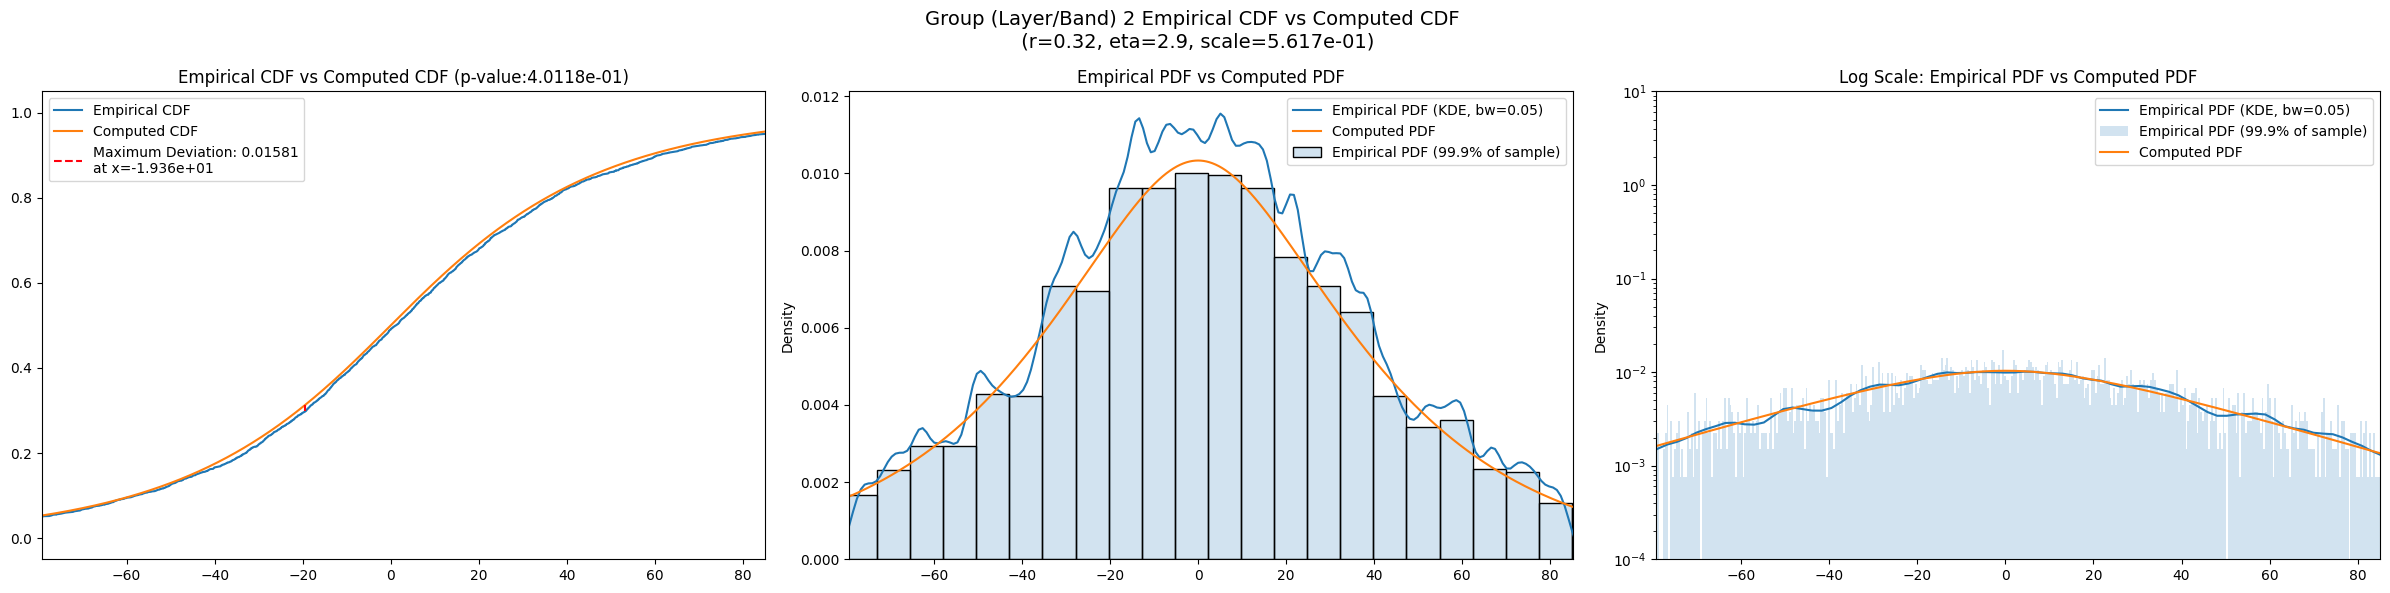

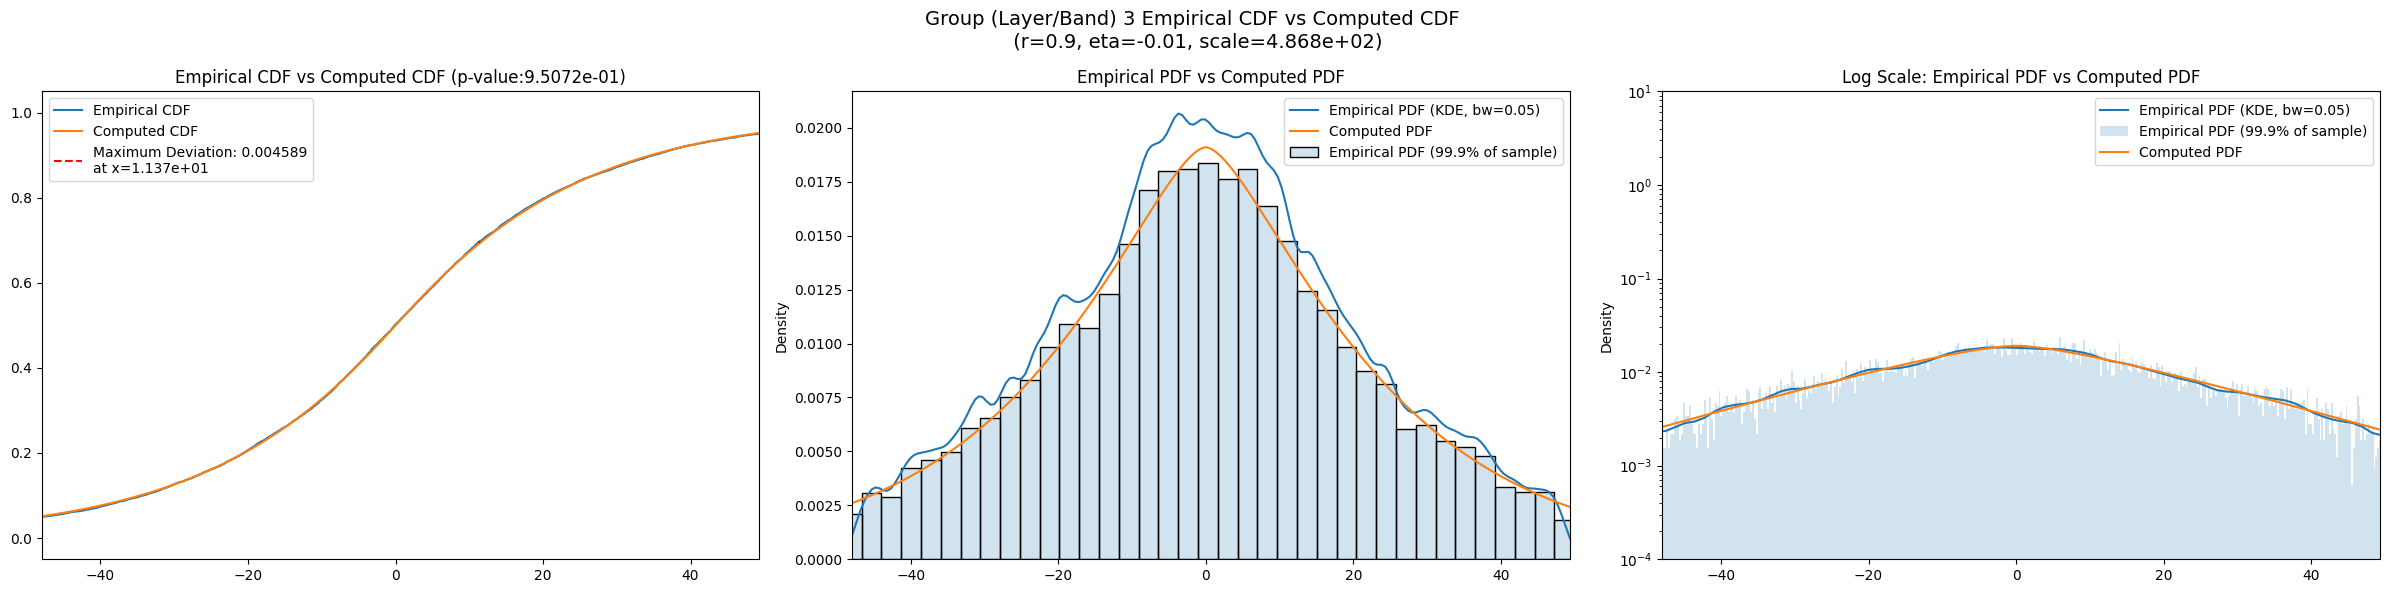

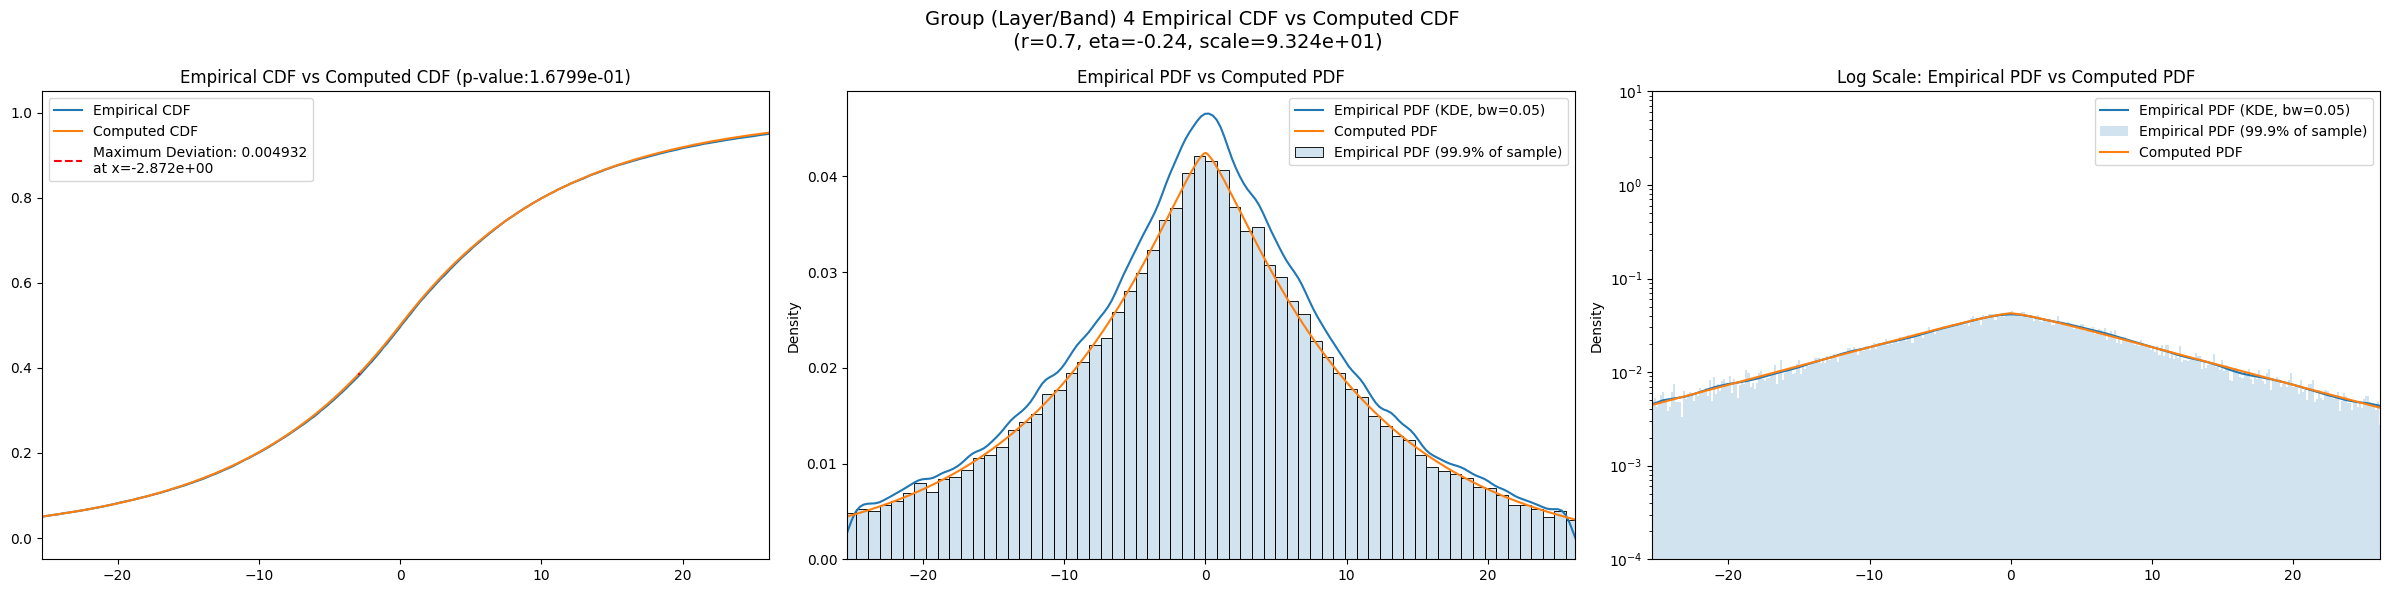

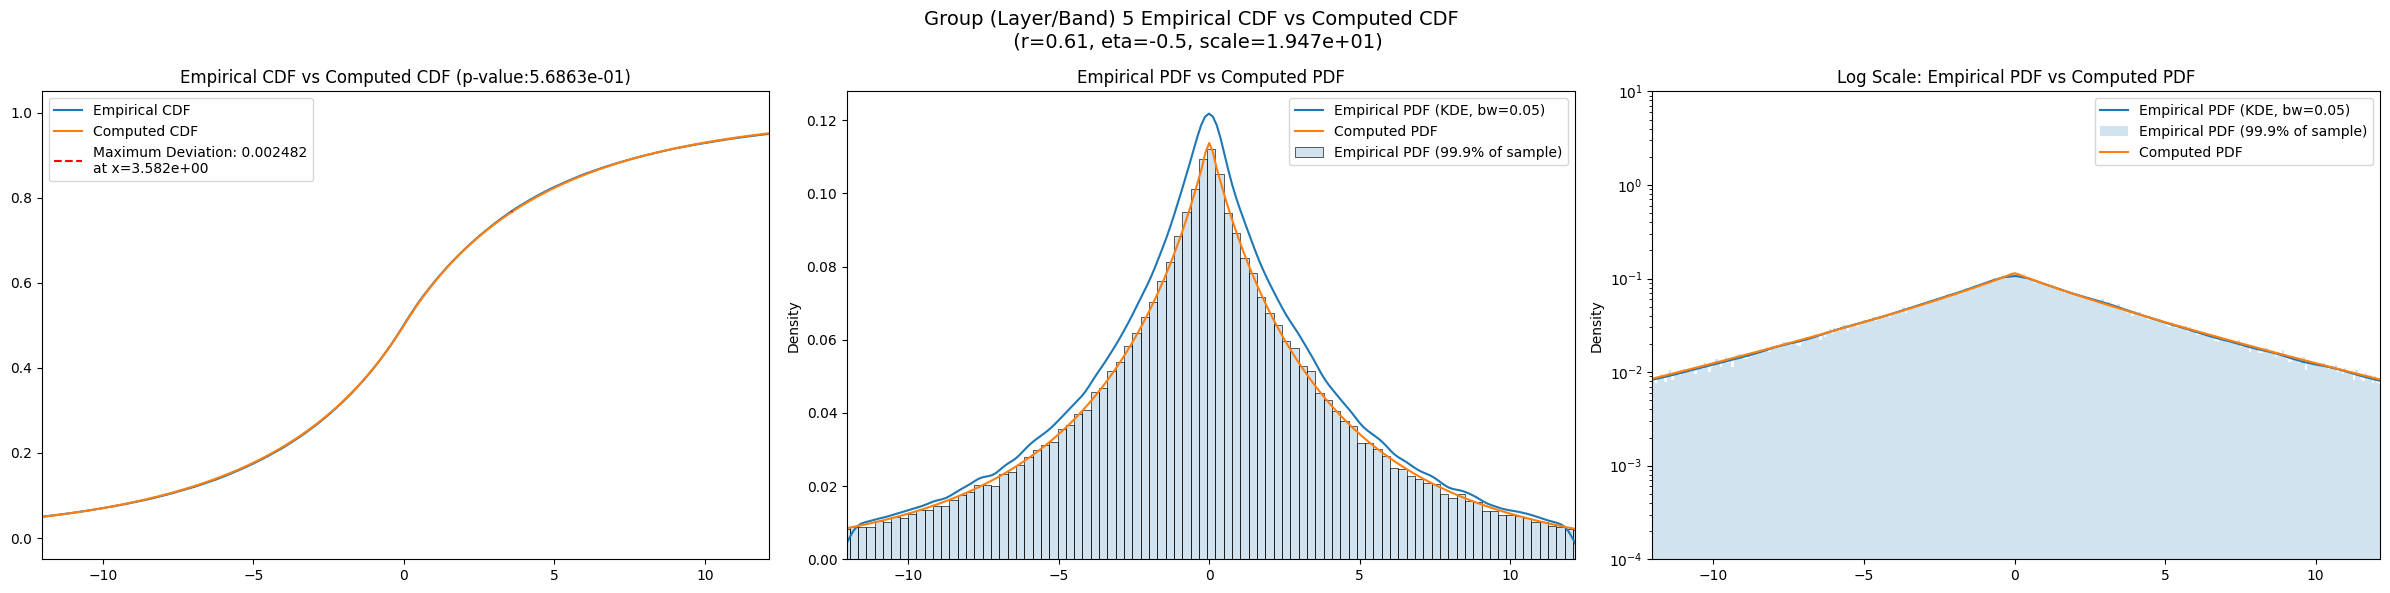

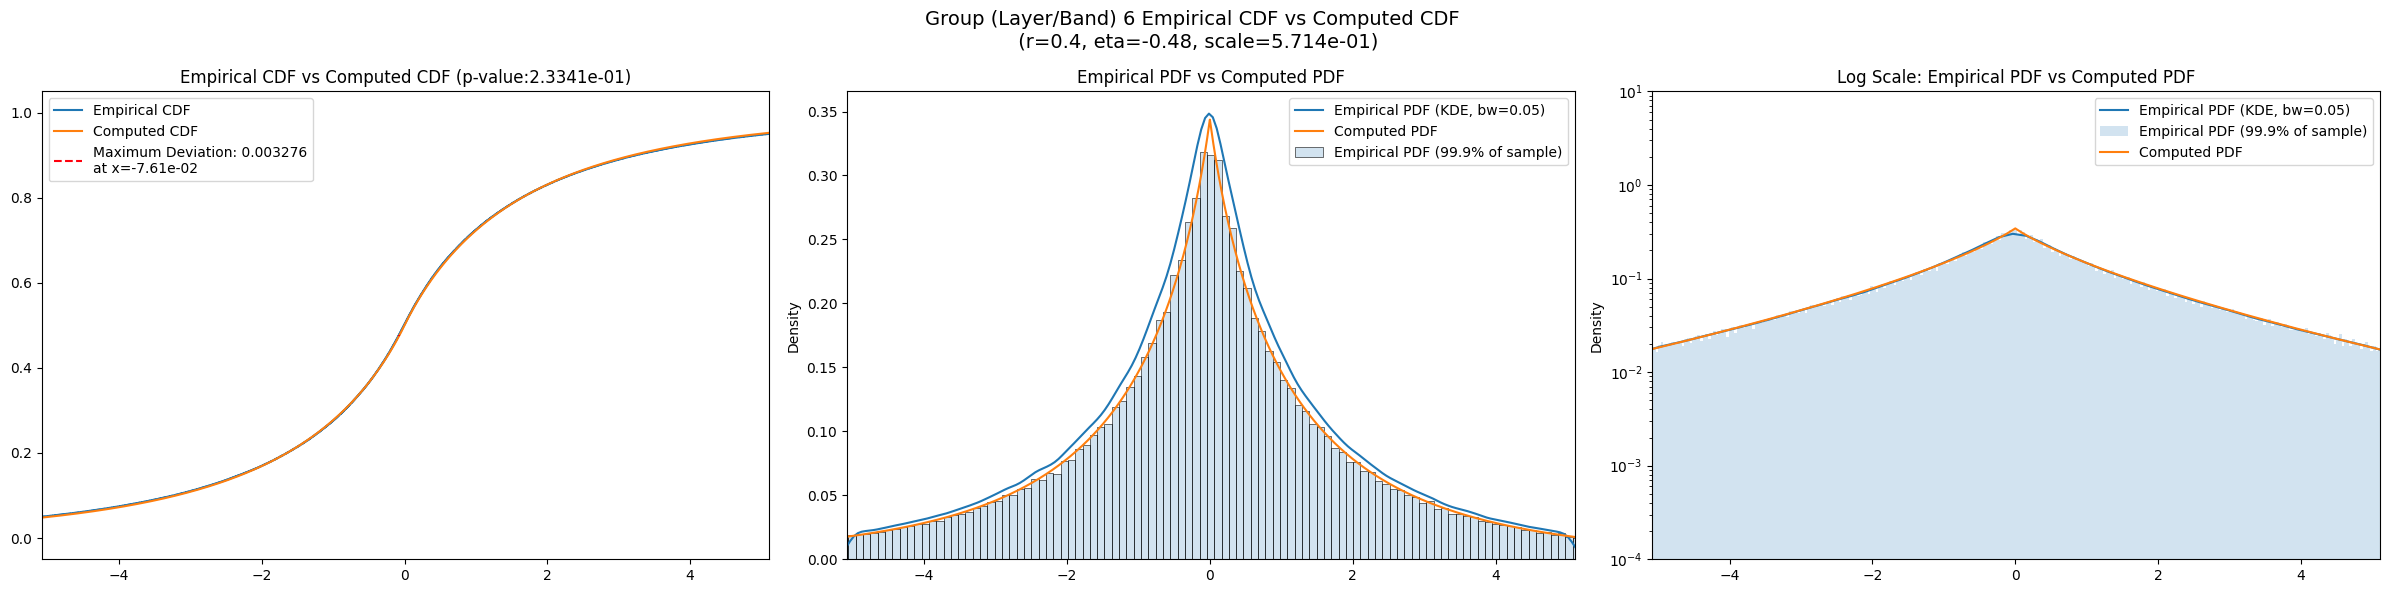

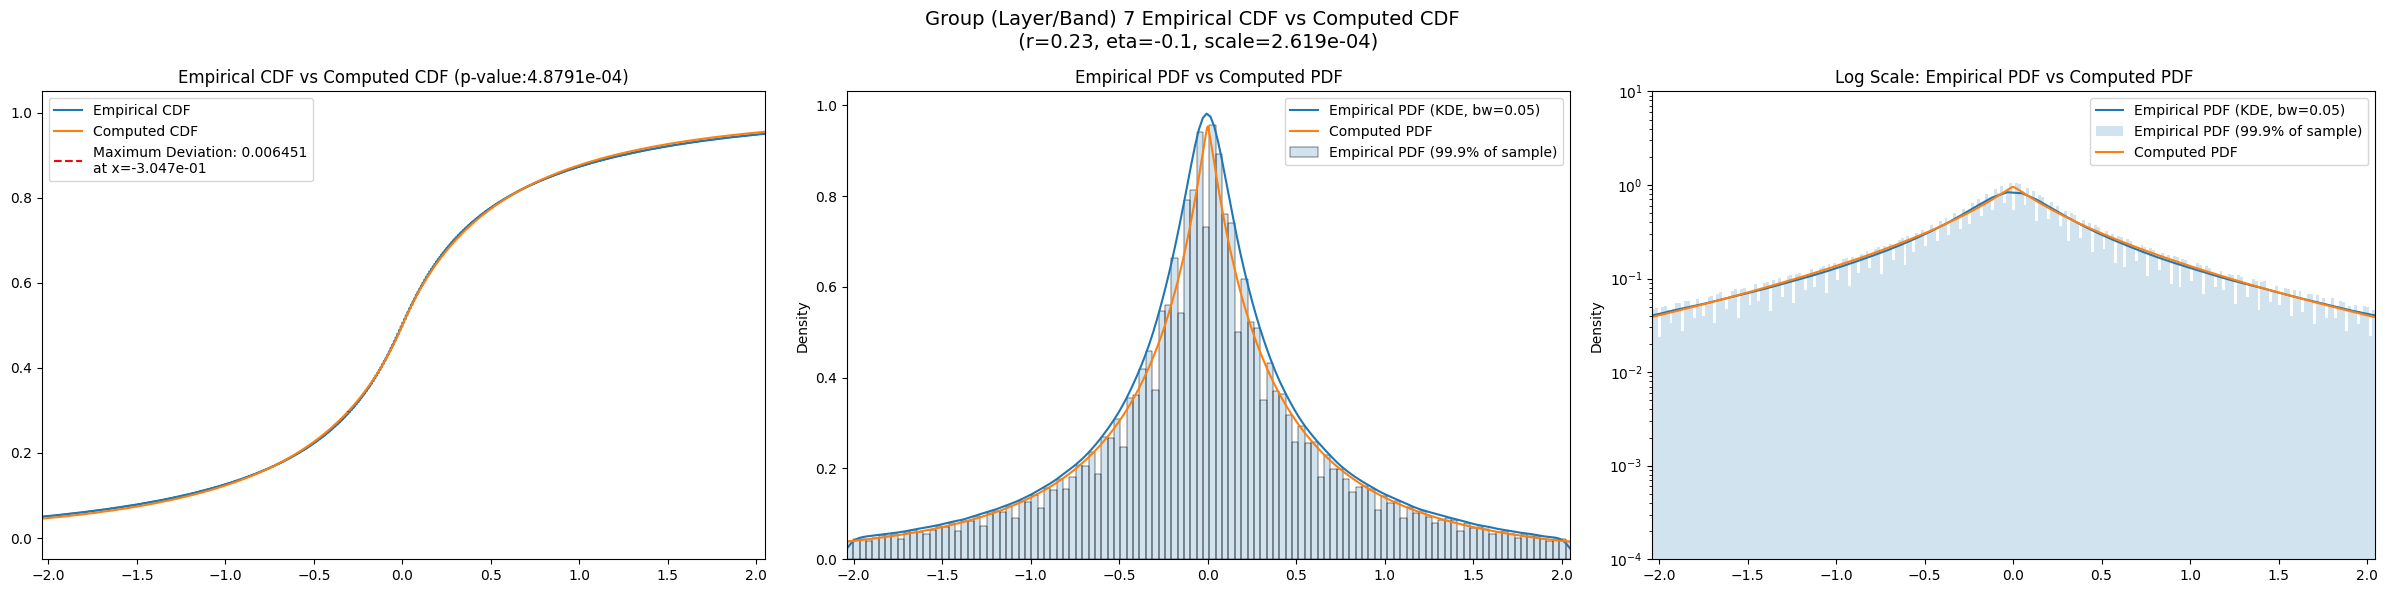

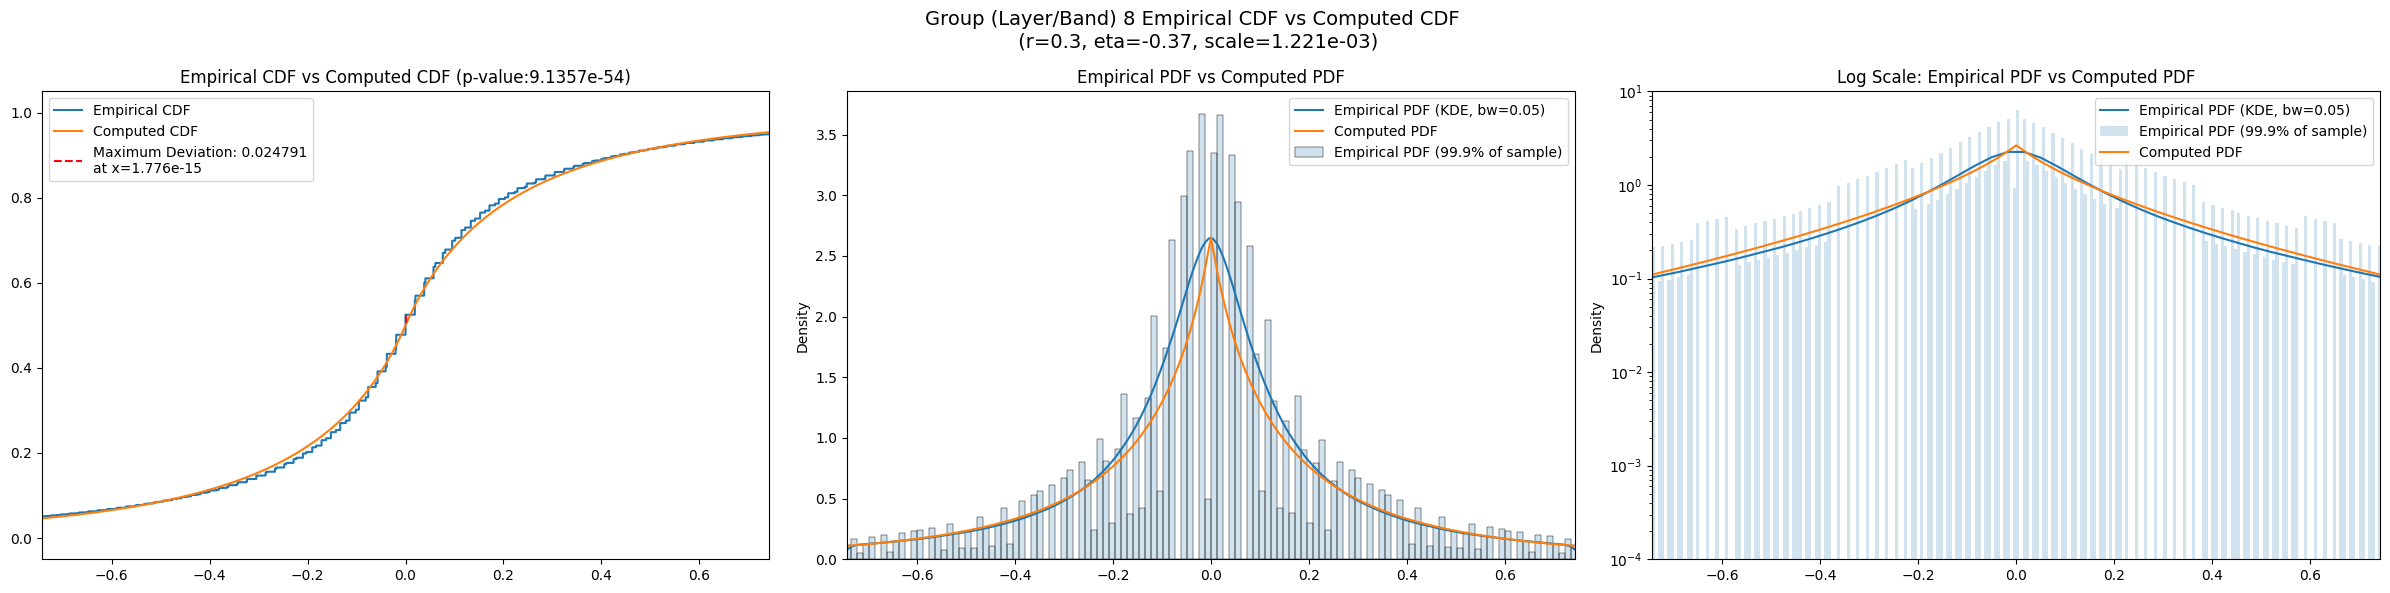

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2543.706000  2322.266800  2776.369900   1.855184    1.231146   
3       880.942400   837.707600   925.666000   1.832932    1.492253   
4       249.724290   236.018890   263.695700   2.604847    2.158933   
5        56.870796    53.349483    60.484978   4.033042    3.357861   
6        10.734995     9.960573    11.537709   5.936091    4.932771   
7         1.834359     1.688523     1.988222   8.154408    6.703937   
8         0.259103     0.236675     0.283873  10.494855    7.995214   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.552742         3180.0             0.015629        0.3          3.2   
3        2.208135        12720.0             0.004665        0.9          0.0   
4        3.140816        50880.0             0.004866        0.9         -0.4   
5        4.833753       203520.0             0.002479        0.6         -0.5   
6        7.195107       814080.0             0.003823        0.4         -0.5   
7       10.309594      3256320.0             0.007234        0.3         -0.4   
8       17.801400     13025280.0             0.024760        0.2          0.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       43.077000              0.028420          1.152580e-02   
3      ...       25.495600              0.024679          3.663890e-07   
4      ...       12.706300              0.031317          8.692540e-44   
5      ...        5.544620              0.037105         6.926350e-244   
6      ...        2.114450              0.046396          0.000000e+00   
7      ...        0.769365              0.054495          0.000000e+00   
8      ...        0.266139              0.058762          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          40.493900             0.023730         5.478760e-02  32.723500   
3          22.415800             0.010855         9.906600e-02  18.281400   
4          11.225900             0.005256         1.198770e-01   9.084320   
5           4.866140             0.009511         2.027720e-16   3.931070   
6           1.848800             0.019017        3.653340e-256   1.478600   
7           0.675367             0.026979         0.000000e+00   0.536496   
8           0.234303             0.031840         0.000000e+00   0.183140   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.021682   9.910870e-02          4.207290e-01  
3           0.015469   4.495120e-03          9.646308e-01  
4           0.010698   1.739190e-05          1.812720e-01  
5           0.012653   9.843920e-29          1.771863e-01  
6           0.021170            NaN          4.287850e-08  
7           0.027880   0.000000e+00         4.680145e-116  
8           0.032822   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015629                 0.024030          0.015556   
3                 0.004665                 0.012029          0.004411   
4                 0.004866                 0.006018          0.004853   
5                 0.002479                 0.003010          0.002439   
6                 0.003823                 0.001505          0.003293   
7                 0.007234                 0.000753          0.006394   
8                 0.024760                 0.000376          0.024760   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.028420             0.023730       0.021682  
3                  0.024679             0.010855       0.015469  
4                  0.031317             0.005256       0.010698  
5                  0.037105             0.009511       0.012653  
6                  0.046396             0.019017       0.021170  
7                  0.054495             0.026979       0.027880  
8                  0.058762             0.031840       0.032822

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta  best_scale  \
layer                                                                       
2             2543.706055          0.015556    0.32      2.90    0.561718   
3              880.942383          0.004411    0.90     -0.01  486.766486   
4              249.724289          0.004853    0.70     -0.24   93.240437   
5               56.870796          0.002439    0.61     -0.50   19.466234   
6               10.734995          0.003293    0.40     -0.48    0.571393   
7                1.834359          0.006394    0.23     -0.10    0.000262   
8                0.235222          0.024760    0.30     -0.37    0.001221   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                    100.0

In [21]:
eng.quit()